In [1]:
import math
import time
import os
import json

import torch as T
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from motion_capture.model.models import find_best_checkpoint, UpsampleCrossAttentionNetwork
from motion_capture.data.datasets import WFLWDataset

In [2]:
checkpoint = find_best_checkpoint("checkpoints/")
network = UpsampleCrossAttentionNetwork.load_from_checkpoint(checkpoint).to("cpu").eval()
dataset = WFLWDataset(
    output_full_image_shape_WH=(224, 224),
    output_face_image_shape_WH=(112, 112),
    image_path="//192.168.2.206/data/datasets/WFLW/images",
    annotation_path="//192.168.2.206/data/datasets/WFLW/annotations",
    max_number_of_faces=6,
    # image_pertubator=ImagePertubators.BASIC()
)

found best model with loss: 0.018864406272768974 from C:\Users\noone\Documents\programming\motion-capture\checkpoints\backbone-general-version_1-epoch=257-step=3870-val_loss=0.0189.ckpt


tested loss: 0.4166666567325592
original loss: 0.25


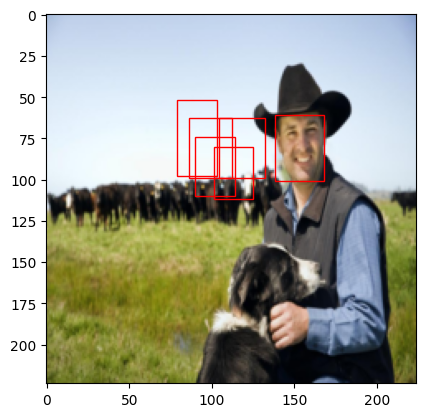

In [20]:
test_i = 8
test_dp = dataset[test_i]

y_ = network(test_dp["fullImage"].unsqueeze(0) / 255)[0]
y_ = (y_ * 224).to(T.int)

plt.imshow(test_dp["fullImage"].permute(1, 2, 0).to(T.uint8))
for bbox in y_:
    x, y = bbox[:2]
    w, h = bbox[2:]
    plt.gca().add_patch(patches.Rectangle(
        (x - w, y - h),
        w * 2, h * 2,
        linewidth=1,
        edgecolor="r",
        facecolor="none"
    ))

# compute loss
tested_loss = T.nn.functional.mse_loss(
    y_.unsqueeze(0), 
    test_dp["faceBboxes"].flatten(-2).unsqueeze(0), 
    reduction="none")
tested_loss = (tested_loss.mean(-1).mean(0) * test_dp['faceValidity'].unsqueeze(0)).mean()

ori_loss = network.compute_loss(
    y_.unsqueeze(0), 
    test_dp['faceBboxes'].flatten(-2).unsqueeze(0), 
    test_dp['faceValidity'].unsqueeze(0))

print(f"tested loss: {tested_loss}")
print(f"original loss: {ori_loss}")


## Interesting Models

In [16]:
most_interesting_models = {
    "vit_b_32": models.get_model("vit_b_32").to("cuda"),
}

models.quantization
models.detection
models.segmentation

<module 'torchvision.models.detection' from 'c:\\Users\\noone\\Documents\\programming\\homemade-motion-capture\\.venv\\lib\\site-packages\\torchvision\\models\\detection\\__init__.py'>

## PyTorch Pretrained Models Speedtest

In [18]:
segmentation_models = {
    "fcn_resnet50": models.segmentation.fcn_resnet50(weights=models.segmentation.FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1),
    "fcn_resnet101": models.segmentation.fcn_resnet101(weights=models.segmentation.FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1),
    "deeplabv3_resnet50": models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1),
    "deeplabv3_resnet101": models.segmentation.deeplabv3_resnet101(weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1),
    "deeplabv3_mobilenet_v3_large": models.segmentation.deeplabv3_mobilenet_v3_large(weights=models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1),
    "lraspp_mobilenet_v3_large": models.segmentation.lraspp_mobilenet_v3_large(weights=models.segmentation.LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1),
}

object_detection_models = {
    "fcos_resnet50_fpn": models.detection.fcos_resnet50_fpn(weights=models.detection.FCOS_ResNet50_FPN_Weights.COCO_V1),
    "fasterrcnn_mobilenet_v3_large_320_fpn": models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=models.detection.FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1),
    "fasterrcnn_mobilenet_v3_large_fpn": models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=models.detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1),
    "fasterrcnn_resnet50_fpn_v2": models.detection.fasterrcnn_resnet50_fpn_v2(weights=models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1),
    "fasterrcnn_resnet50_fpn": models.detection.fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1),
    "retinanet_resnet50_fpn_v2": models.detection.retinanet_resnet50_fpn_v2(weights=models.detection.RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1),
    "retinanet_resnet50_fpn": models.detection.retinanet_resnet50_fpn(weights=models.detection.RetinaNet_ResNet50_FPN_Weights.COCO_V1),
    "ssd300_vgg16": models.detection.ssd300_vgg16(weights=models.detection.SSD300_VGG16_Weights.COCO_V1),
    "ssdlite320_mobilenet_v3_large": models.detection.ssdlite320_mobilenet_v3_large(weights=models.detection.SSDLite320_MobileNet_V3_Large_Weights.COCO_V1),
}

instance_segmentation_models = {
    "maskrcnn_resnet50_fpn": models.detection.maskrcnn_resnet50_fpn(weights=models.detection.MaskRCNN_ResNet50_FPN_Weights.COCO_V1),
    "maskrcnn_resnet50_fpn_v2": models.detection.maskrcnn_resnet50_fpn_v2(weights=models.detection.MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1),
}

keypoint_detection_models = {
    "keypointrcnn_resnet50_fpn": models.detection.keypointrcnn_resnet50_fpn(weights=models.detection.KeypointRCNN_ResNet50_FPN_Weights.COCO_V1),
}

## Facer

In [19]:
import facer

In [35]:
facer_models = {
    # "retinaface/mobilenet": facer.face_detector("retinaface/mobilenet", device="cuda"),
    # "retinaface/resnet": facer.face_detector("retinaface/resnet50", device="cuda"),
    "farl/lapa/448": facer.face_parser("farl/lapa/448", device="cuda"),
    "farl/celebm/448": facer.face_parser("farl/celebm/448", device="cuda"),
    "farl/ibug300w/448": facer.face_aligner("farl/ibug300w/448", device="cuda"),
    "farl/aflw19/448": facer.face_aligner("farl/aflw19/448", device="cuda"),
    "farl/wflw/448": facer.face_aligner("farl/wflw/448", device="cuda"),
    "farl/celeba/224": facer.face_attr("farl/celeba/224", device="cuda")
}